In [23]:
import json
import matplotlib.pyplot as plt
import numpy as np

path = "Logged robustness"

model_names = ["Adam", "SWA", "Noise"]
# model_names = ["Adam", "Noise"]

robe = ["fgsm", "flat", "mask", "corrupted"]

data = {}

In [24]:
for rob in robe:
    data[rob] = {}
    for x in model_names:
        with open(path + f"/{rob}_{x}.json", 'r') as file:
            data[rob][x] = json.load(file)

colors = {
    "SWA": "blue",
    "Adam": "green",
    "Noise": "black"
}

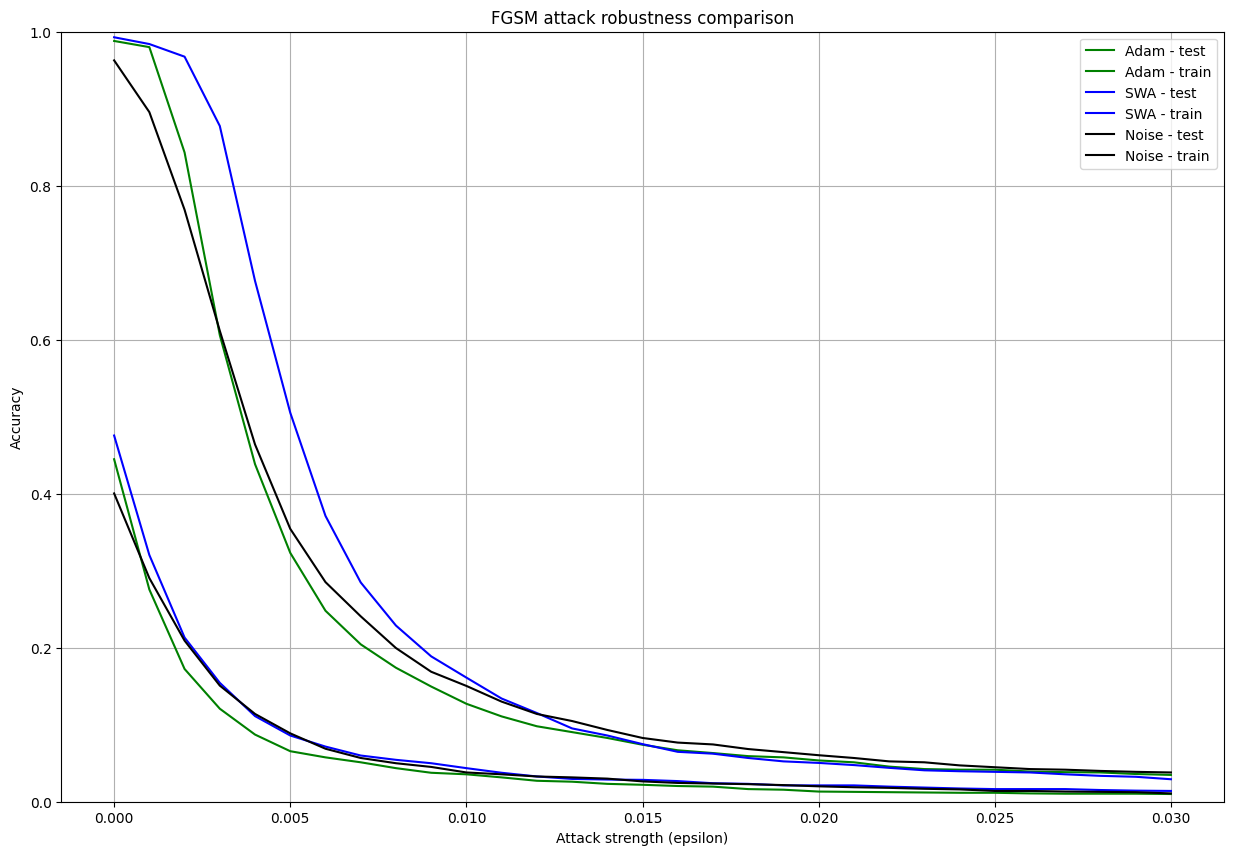

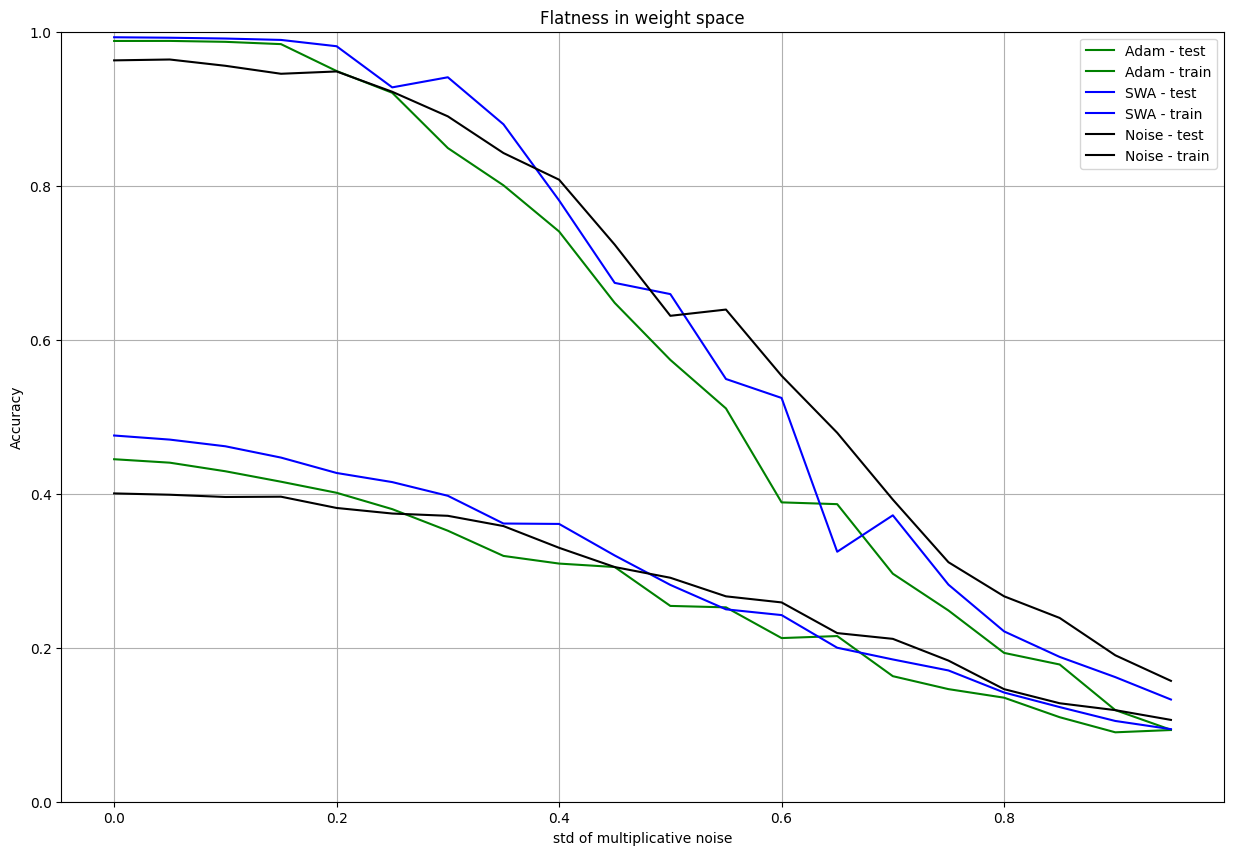

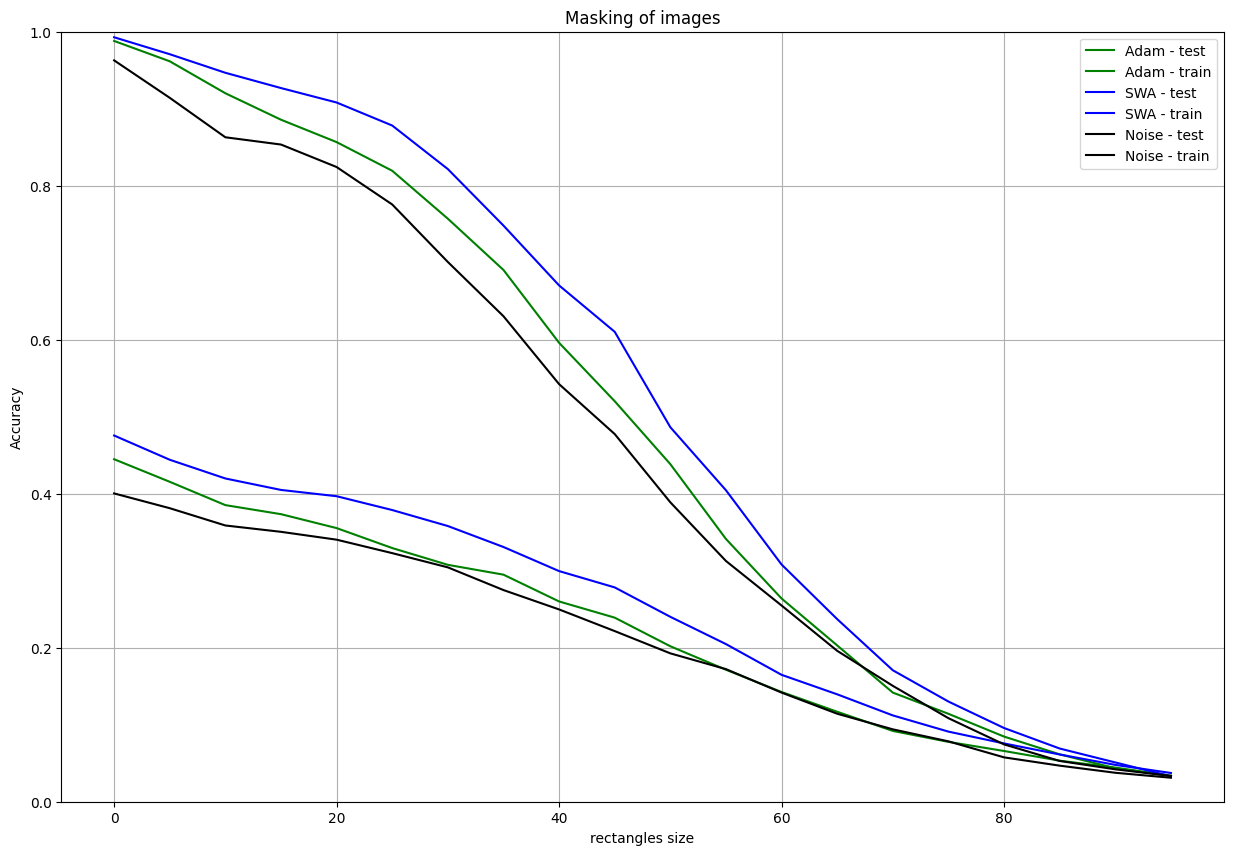

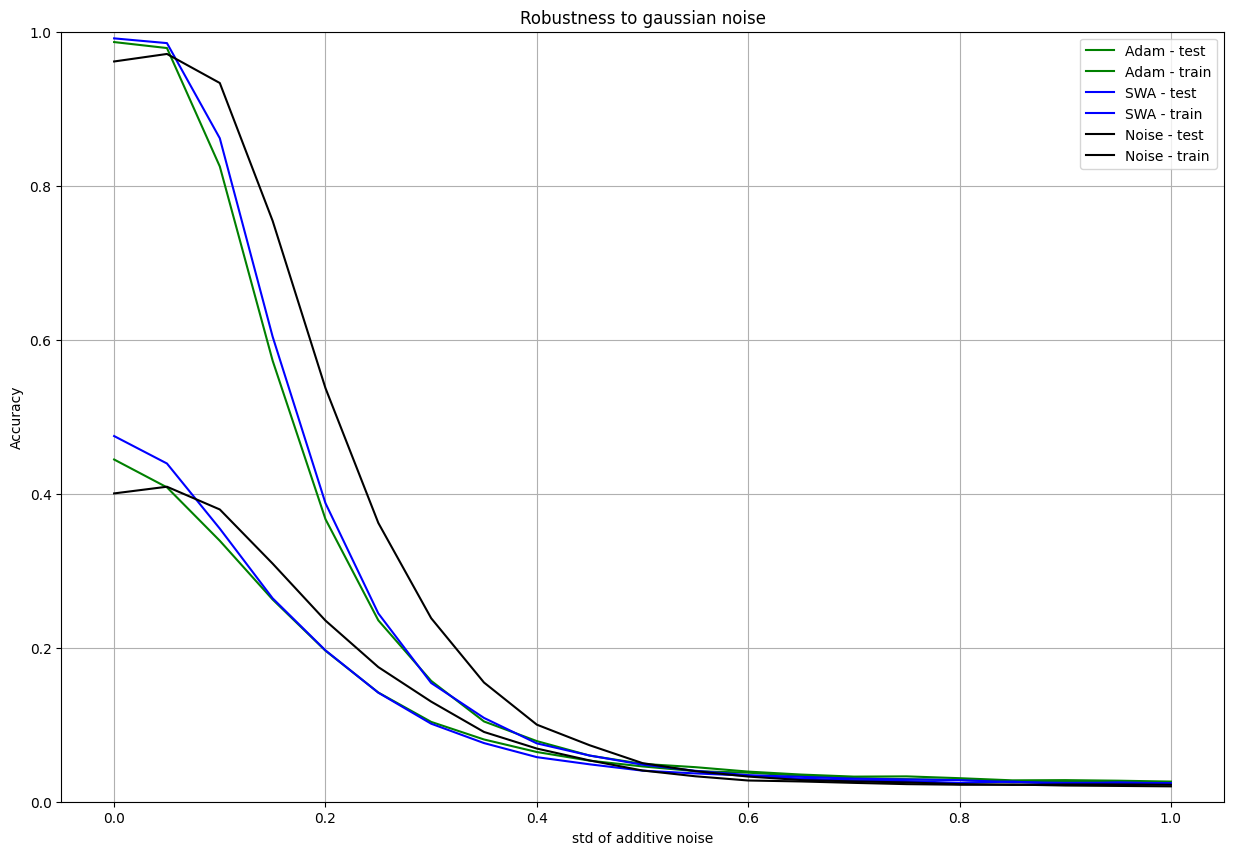

In [25]:
multiple = False

if multiple:
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    # fig.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.28, hspace=None)
    i = 0


def plot_comparison_accuracy(title, xlab, datas, names, key, is_acc=True):

    if multiple:
        global i
        ax1 = ax[i // 2][i % 2]
        i += 1
    else:
        fig, ax1 = plt.subplots(figsize=(15,10))
        # ax1.figure(figsize=(20,10))
    d = "accuracies" if is_acc else "losses"
    for x in names:
        ax1.plot(datas[x][key], datas[x][f"test_{d}"], label=f"{x} - test", color=colors[x])
        ax1.plot(datas[x][key], datas[x][d], label=f"{x} - train", color=colors[x])

    if is_acc:
        ax1.set_ylim(0, 1)
        ax1.set_ylabel("Accuracy")
    else:
        ax1.set_ylabel("CrossEntropy")
    ax1.set_xlabel(xlab)
    ax1.legend()
    ax1.set_title(title)
    ax1.grid()
    if not multiple:
        plt.show()

is_acc = True

for rob in robe:
    if rob == "fgsm":
        plot_comparison_accuracy(f"FGSM attack robustness comparison", "Attack strength (epsilon)", data[rob],
                                 model_names, "epss", is_acc=is_acc)
    elif rob == "flat":
        plot_comparison_accuracy(f"Flatness in weight space", "std of multiplicative noise", data[rob], model_names,
                                 "sigmas", is_acc=is_acc)
    elif rob == "corrupted":
        plot_comparison_accuracy(f"Robustness to gaussian noise", "std of additive noise", data[rob], model_names,
                                 "sigmas", is_acc=is_acc)
    elif rob == "mask":
        plot_comparison_accuracy(f"Masking of images", "rectangles size", data[rob], model_names, "dxs", is_acc=is_acc)


if multiple: plt.show()


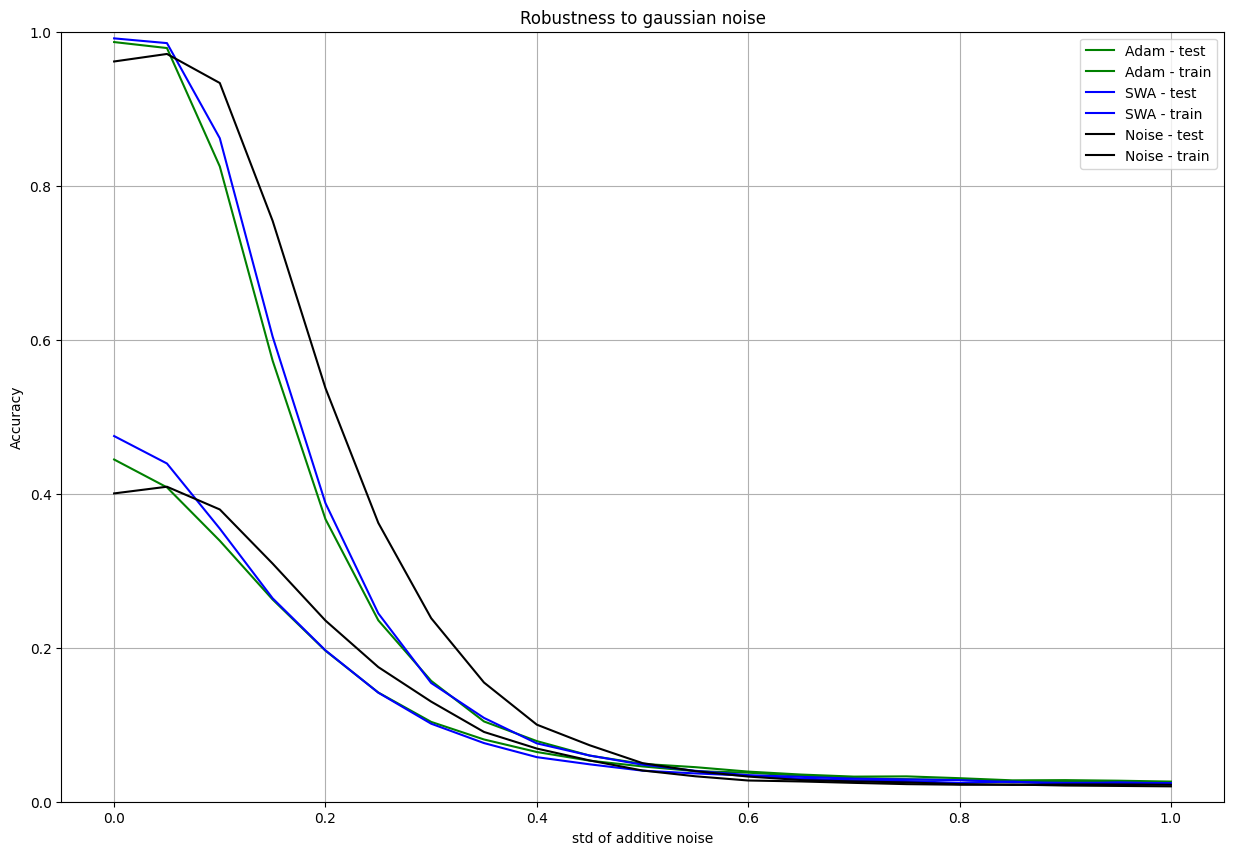

In [26]:
plot_comparison_accuracy(f"Robustness to gaussian noise", "std of additive noise", data["corrupted"], model_names,
                         "sigmas", is_acc=True)

In [27]:
from torchvision.models import resnet18

m = resnet18(num_classes=10)
n_params = sum(p.numel() for p in m.parameters())
del m


# Finetuning

In [49]:
import numpy as np

finetuning_data = {}

lrs = ["", "_lr=0.001", "_lr=0.0005", "_lr=5e-05"]

lr = lrs[2]

for x in model_names:
    finetuning_data[x] = []
    for i in range(100):
        try:
            with open(f"finetuning/{x}_{i}{lr}.json", 'r') as file:
                finetuning_data[x].append(json.load(file))
        except:
            break



In [50]:
finetuning_avg = {}

metrics = ["losses", "test_losses", "accuracies", "test_accuracies", "correlations"]

for m in metrics:
    finetuning_avg[m] = {}
    finetuning_avg[m + "std"] = {}
    for x in model_names:
        if m != "correlations":
            finetuning_avg[m][x] = np.mean([p[m] for p in finetuning_data[x]], axis=0)
            finetuning_avg[m + "std"][x] = np.std([p[m] for p in finetuning_data[x]], axis=0, ddof=1)
        else:
            # if "swa" in x.lower():
            #     array = np.array([[0.0] + p[m] for p in finetuning_data[x]])
            # else:
            array = np.array([p[m] for p in finetuning_data[x]])
            array *= n_params
            array = np.sqrt(array)
            array/= n_params

            finetuning_avg[m][x] = np.mean(array, axis=0)
            finetuning_avg[m + "std"][x] = np.std(array, axis=0, ddof=1)


In [51]:
def plot(data, metrics, names, err_bar=False, title=None):
    plt.figure(figsize=(15, 8))
    for metric in metrics:
        for n in names:
            if err_bar:
                plt.errorbar(list(range(len(data[metric][n]))), data[metric][n], yerr=data[metric + "std"][n],
                             capsize=5,
                             label=f"{metric} {n}")
            else:
                plt.plot(data[metric][n], label=n)

        if "acc" in metric:
            plt.ylim(0, 1)
            plt.ylim(.7, 1)
            plt.ylabel("Accuracy")
        elif "loss" in metric:
            plt.ylabel("CrossEntropy")
        else:
            plt.ylabel("Distance from starting model")

    if title is None:
        title = metrics[0]
    plt.title(title)
    plt.grid()
    plt.legend()

    plt.xlabel("Epochs")
    plt.show()

In [52]:
finetuning_avg["test_accuracies"]

{'Adam': array([0.74905, 0.72695, 0.7895 , 0.7893 , 0.7817 , 0.77805, 0.78595,
        0.79395, 0.7767 , 0.76985, 0.7874 , 0.7762 , 0.7589 , 0.79025,
        0.7853 ]),
 'SWA': array([0.73005, 0.7695 , 0.76975, 0.785  , 0.76575, 0.7854 , 0.7958 ,
        0.7927 , 0.78735, 0.78385, 0.7772 , 0.79265, 0.7925 , 0.77135,
        0.80185]),
 'Noise': array([0.77565, 0.7913 , 0.745  , 0.78925, 0.77455, 0.76835, 0.7752 ,
        0.79185, 0.78605, 0.7845 , 0.78585, 0.80005, 0.7635 , 0.77605,
        0.80085])}

In [53]:
finetuning_avg["accuracies"]

{'Adam': array([0.69165, 0.85979, 0.94408, 0.98474, 0.98943, 0.986  , 0.98213,
        0.98919, 0.99096, 0.98903, 0.98984, 0.99104, 0.98951, 0.99108,
        0.99264]),
 'SWA': array([0.70137, 0.85754, 0.93549, 0.97473, 0.9835 , 0.98235, 0.98481,
        0.98566, 0.98759, 0.98962, 0.98889, 0.98962, 0.98994, 0.99167,
        0.99012]),
 'Noise': array([0.69534, 0.86337, 0.94815, 0.98518, 0.99134, 0.9876 , 0.98376,
        0.98713, 0.99027, 0.99276, 0.99113, 0.9894 , 0.99078, 0.993  ,
        0.99316])}

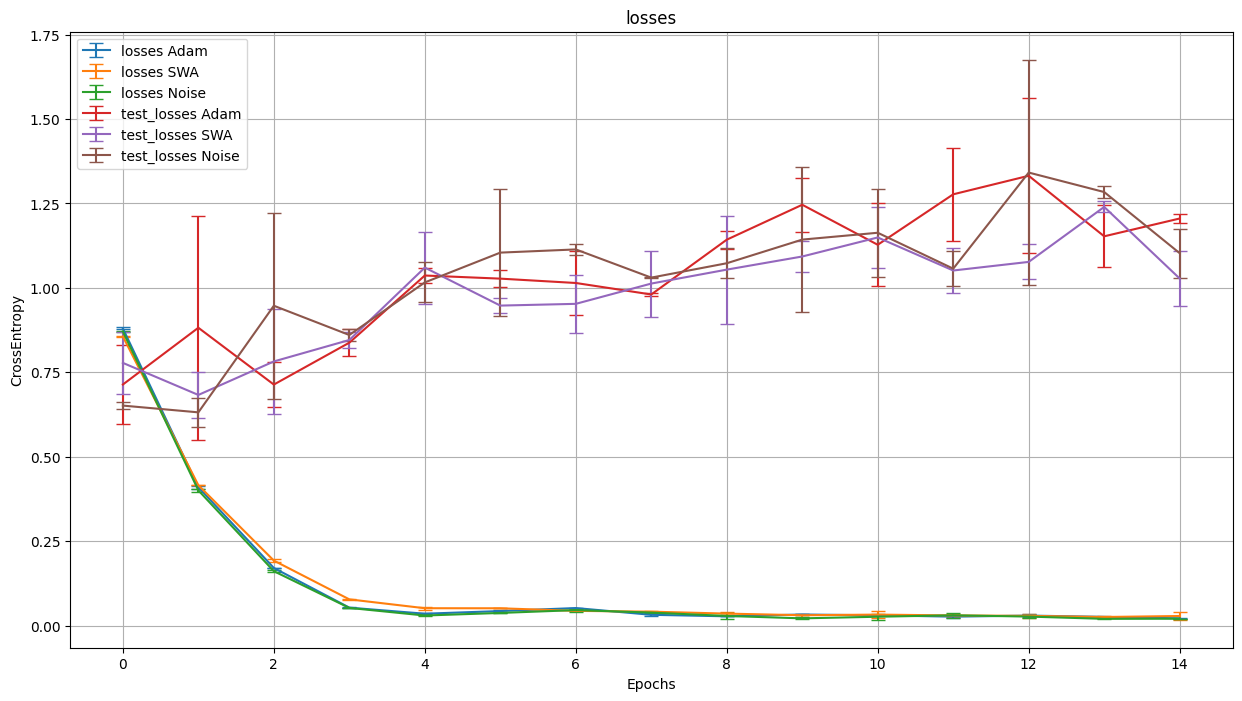

In [54]:
plot(finetuning_avg, ["losses", "test_losses"], model_names, err_bar=True)

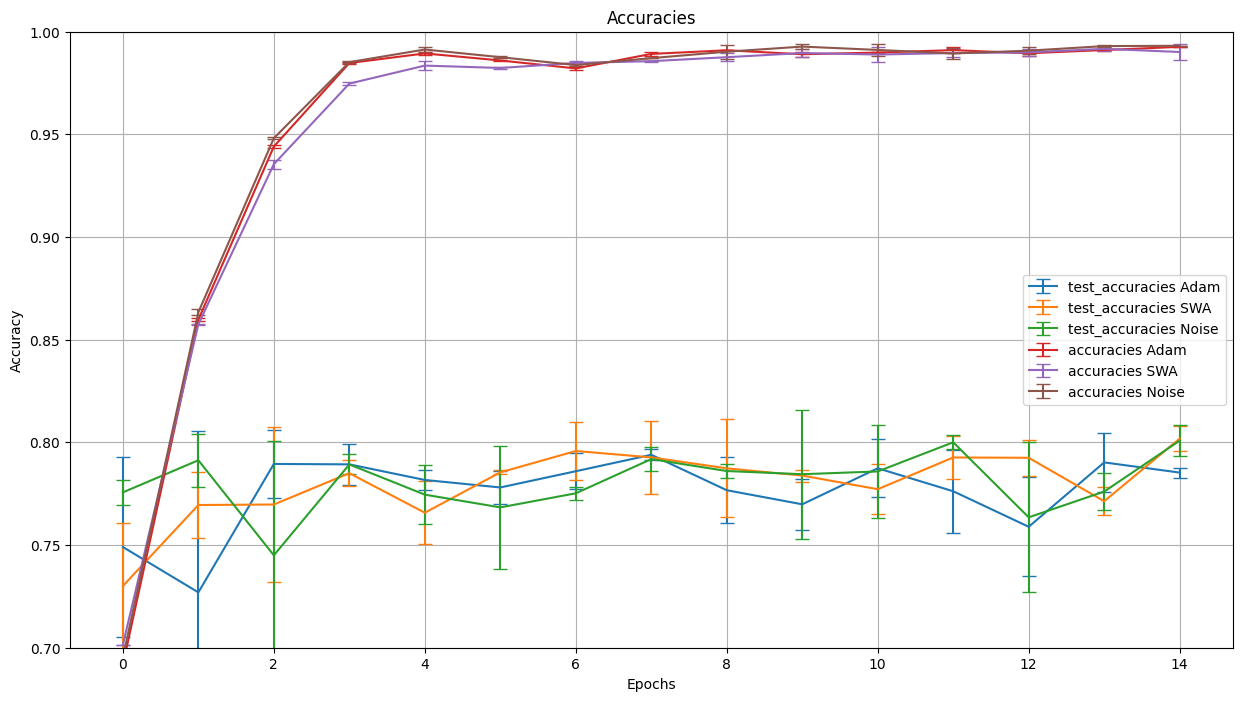

In [55]:
plot(finetuning_avg, ["test_accuracies", "accuracies"], model_names, err_bar=True, title="Accuracies")

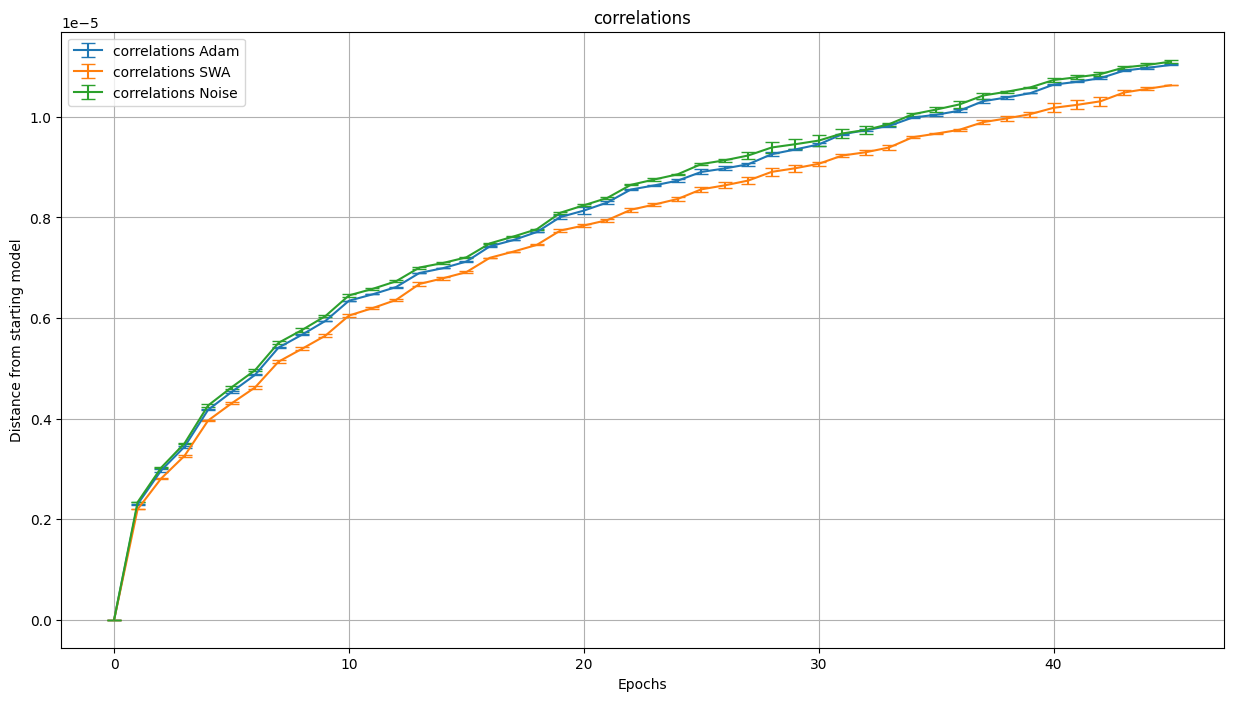

In [56]:
plot(finetuning_avg, ["correlations"], model_names, err_bar=True)